<a href="https://colab.research.google.com/github/mjassiri/Student-Grade-Tracker/blob/main/student_grade_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

In [118]:
# Mount Google Drive
drive.mount('/content/drive')

# Create directory structure
base_dir = '/content/drive/My Drive/StudentGradeTracker'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/reports', exist_ok=True)

print(f"Directory created at: {base_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory created at: /content/drive/My Drive/StudentGradeTracker


In [119]:
class Student:
    def __init__(self, student_id: int, name: str, email: str):
        self.student_id = student_id
        self.name = name
        self.email = email

    def to_dict(self):
        return {
            "student_id": self.student_id,
            "name": self.name,
            "email": self.email
        }

In [120]:
class Course:
    def __init__(self, course_id: int, name: str, credits: int):
        self.course_id = course_id
        self.name = name
        self.credits = credits

    def to_dict(self):
        return {
            "course_id": self.course_id,
            "course_name": self.name,
            "credits": self.credits
        }

In [121]:
class GradeManager:
    def __init__(self):
        self.students = pd.DataFrame(columns=["student_id", "name", "email"])
        self.courses = pd.DataFrame(columns=["course_id", "course_name", "credits"])
        self.grades = pd.DataFrame(columns=["student_id", "course_id", "grade", "semester"])
        self.base_dir = '/content/drive/My Drive/StudentGradeTracker'

    def add_student(self, student: Student):
        self.students = pd.concat([self.students, pd.DataFrame([student.to_dict()])], ignore_index=True)

    def add_course(self, course: Course):
        self.courses = pd.concat([self.courses, pd.DataFrame([course.to_dict()])], ignore_index=True)

    def add_grade(self, student_id: int, course_id: int, grade: float, semester: str):
        new_grade = pd.DataFrame([{
            "student_id": student_id,
            "course_id": course_id,
            "grade": grade,
            "semester": semester
        }])
        self.grades = pd.concat([self.grades, new_grade], ignore_index=True)

    def save_data(self):
        self.students.to_csv(f"{self.base_dir}/students.csv", index=False)
        self.courses.to_csv(f"{self.base_dir}/courses.csv", index=False)
        self.grades.to_csv(f"{self.base_dir}/grades.csv", index=False)

    def load_data(self):
        self.students = pd.read_csv(f"{self.base_dir}/students.csv")
        self.courses = pd.read_csv(f"{self.base_dir}/courses.csv")
        self.grades = pd.read_csv(f"{self.base_dir}/grades.csv")

    def get_student_tuple(self, student_id: int) -> tuple:
      """Returns a tuple (student_id, name, email) for the given student_id."""
      student_row = self.students[self.students["student_id"]== student_id]
      if student_row.empty:
        return None
      row = student_row.iloc[0]
      return (row["student_id"], row["name"], row["email"])


    def get_students_in_course(self, course_id: int) -> set:
      """Returns a set of all the unique student IDs enrolled in a given course."""
      return set(self.grades[self.grades["course_id"] == course_id]["student_id"])

In [122]:
class AnalyticsEngine:
    def __init__(self, grade_manager: GradeManager):
        self.gm = grade_manager

    def calculate_gpa(self, student_id: int) -> float:
        merged = pd.merge(
            self.gm.grades[self.gm.grades["student_id"] == student_id],
            self.gm.courses,
            on="course_id"
        )
        return np.average(merged["grade"], weights=merged["credits"])

    def plot_grade_distribution(self, course_id: int, save_to_drive: bool = False):
        plt.figure(figsize=(10, 6))
        sns.histplot(
            self.gm.grades[self.gm.grades["course_id"] == course_id]["grade"],
            kde=True
        )
        plt.title(f"Grade Distribution for Course {course_id}")
        if save_to_drive:
            plt.savefig(f"{self.gm.base_dir}/reports/course_{course_id}_distribution.png")
        plt.show()

    def plot_violin_for_course(self, course_id: int, save_to_drive: bool = False):
    # Filter grades for the given course_id
      course_grades = self.gm.grades[self.gm.grades["course_id"] == course_id]["grade"]

      plt.figure(figsize=(10, 6))
      sns.violinplot(x=course_grades)
      plt.title(f"Violin Plot for Course {course_id}")
      plt.xlabel("Grade")
      if save_to_drive:
          plt.savefig(f"{self.gm.base_dir}/reports/course_{course_id}_violin_plot.png", bbox_inches='tight')
      plt.show()

In [123]:
# Install the Faker library if you haven't already
!pip install faker

from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Number of fake entries you want to generate
num_students = 100
num_courses = 5

# Create fake students
students_list = []
for i in range(1, num_students + 1):
    student = Student(
        student_id=i,
        name=fake.name(),
        email=fake.email()
    )
    students_list.append(student)

# Define some fake course names and create fake courses
course_names = ["Mathematics", "History", "Biology", "Computer Science", "Art"]
courses_list = []
for idx, name in enumerate(course_names, start=101):
    course = Course(
        course_id=idx,
        name=name,
        credits=random.choice([2, 3, 4])
    )
    courses_list.append(course)

# Initialize your GradeManager and add the fake students and courses
gm = GradeManager()
for student in students_list:
  gm.add_student(student)


for course in courses_list:
    gm.add_course(course)

# Generate fake grades:
# For each student, assign a random grade for each course in a given semester
for student in students_list:
  num_courses_for_student = random.randint(2, 4)
  selected_courses = random.sample(courses_list, num_courses_for_student)

  for course in selected_courses:
      # Generate a random grade between 50 and 100
      mean_grade = 75
      std_dev = 10
      generated_grade = np.random.normal(loc=mean_grade, scale=std_dev)
      generated_grade = int(round(generated_grade))
      generated_grade = max(0, min(100, generated_grade))
      gm.add_grade(student.student_id, course.course_id, generated_grade, "Fall 2024")

# Now that gm is populated, create the AnalyticsEngine
analytics = AnalyticsEngine(gm)

# Optionally, save your fake data to Google Drive
gm.save_data()

print("Fake data added successfully!")


Fake data added successfully!


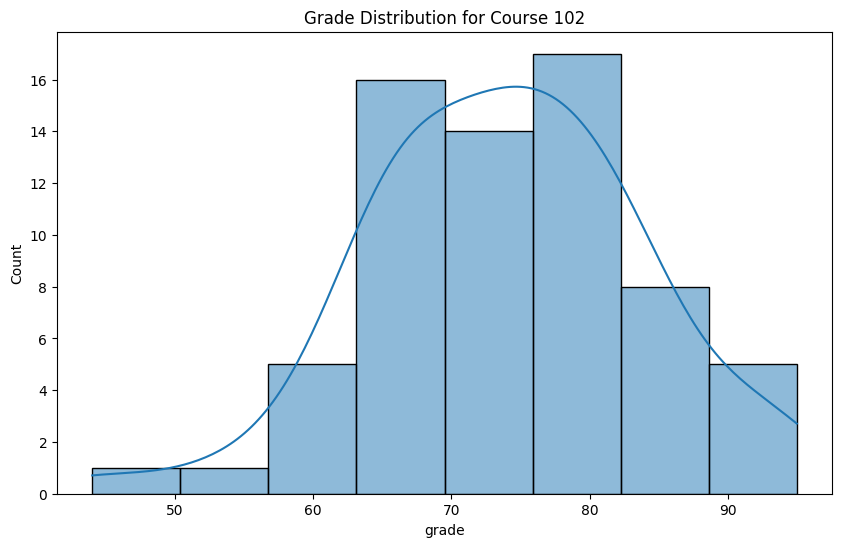

In [124]:
analytics.plot_grade_distribution(102, save_to_drive=False)

In [125]:
print(gm.grades[gm.grades["course_id"] == 102])


    student_id course_id grade   semester
3            2       102    76  Fall 2024
7            3       102    73  Fall 2024
15           6       102    83  Fall 2024
19           7       102    64  Fall 2024
20           8       102    80  Fall 2024
..         ...       ...   ...        ...
281         93       102    75  Fall 2024
288         95       102    66  Fall 2024
292         96       102    76  Fall 2024
296         97       102    79  Fall 2024
302         99       102    68  Fall 2024

[67 rows x 4 columns]


count     67
unique    33
top       73
freq       5
Name: grade, dtype: int64


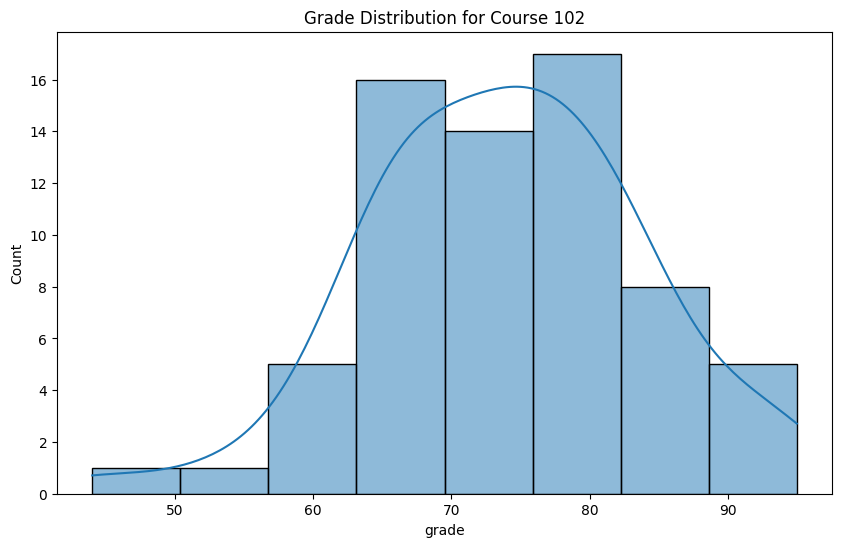

In [126]:
# Get the grades for course 102
course_grades = gm.grades[gm.grades["course_id"] == 102]["grade"]
print(course_grades.describe())

# Then plot the distribution
analytics.plot_grade_distribution(102, save_to_drive=True)


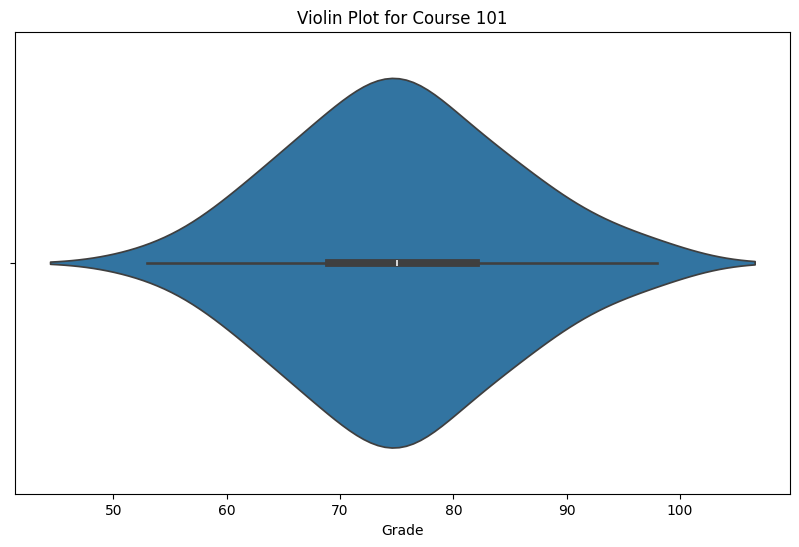

In [127]:
analytics.plot_violin_for_course(101, save_to_drive=True)

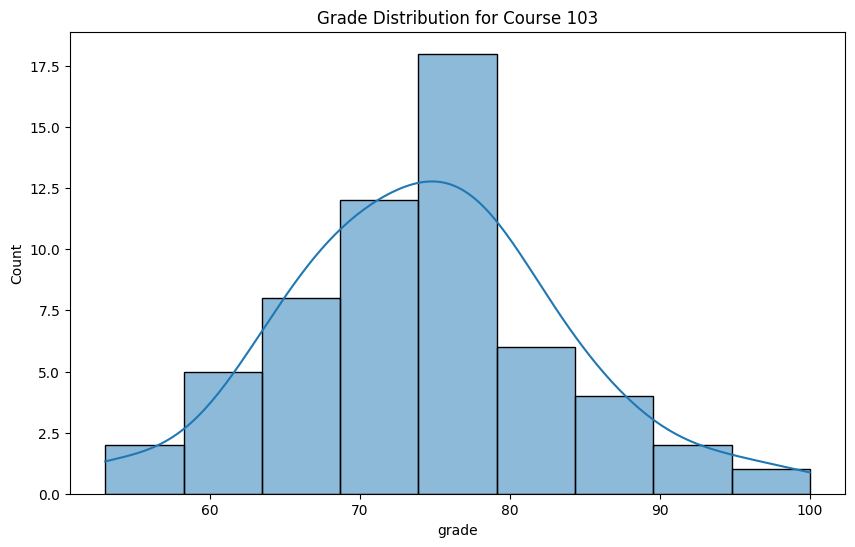

In [128]:
analytics.plot_grade_distribution(103, save_to_drive=True)

In [129]:
student_info = gm.get_student_tuple(1)
print(student_info)
student_info73 = gm.get_student_tuple(73)
print(student_info73)


(1, 'Michelle Richardson', 'rodgersolivia@example.org')
(73, 'Carol Jones', 'sergio71@example.net')


In [130]:
math_students = gm.get_students_in_course(101)
cs_students = gm.get_students_in_course(104)
common_students = math_students.intersection(cs_students)
print("Students taking both Mathematics and Computer Science:", common_students)


Students taking both Mathematics and Computer Science: {4, 5, 6, 13, 16, 28, 30, 33, 37, 38, 39, 41, 42, 44, 45, 49, 54, 57, 66, 67, 69, 75, 76, 82, 85, 89, 91, 92, 94, 96}
